In [1]:
import numpy as np
import matplotlib.pyplot as plt

### discrete fourier transform

In [2]:
def dft_k(x, k):
    t = np.linspace(0, 1, len(x), endpoint=False)
    e = np.exp(-1j * 2 * np.pi * k * t)
    return (x @ e) * np.sqrt(1/len(x))

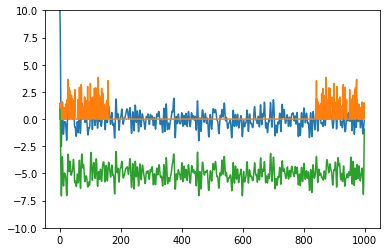

In [3]:
x = sum(np.cos(np.linspace(0, x_, num=1000)) for x_ in np.random.rand(100)*1000)/10
f = np.array([dft_k(x,k) for k in range(1000)])
f = np.where(abs(f)>1, f, 0j)
y = np.array([dft_k(f,-k) for k in range(1000)])
plt.plot(x)
plt.plot(abs(f))
plt.plot(np.real(y)-5)
plt.ylim((-10,10))
plt.show()

### discrete cosine transform type 4

In [4]:
def dct_iv_k(x, k):
    n = np.linspace(0,len(x),len(x),endpoint=False)
    c = np.cos((np.pi/len(x))*(n+0.5)*(k+0.5))
    return (x @ c) * np.sqrt(2/len(x))

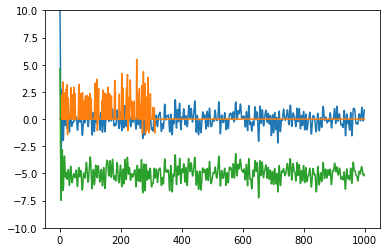

In [5]:
x = sum(np.cos(np.linspace(0, x_, num=1000)) for x_ in np.random.rand(100)*1000)/10
#x = np.cos(np.linspace(0, 100, num=1000))
f = np.array([dct_iv_k(x,k) for k in range(1000)])
f = np.where(abs(f)>1, f, 0)
y = np.array([dct_iv_k(f,k) for k in range(1000)])
plt.plot(x)
plt.plot(f)
plt.plot(y-5)
plt.ylim((-10,10))
plt.show()

### modified discrete cosine transform

In [6]:
def dct_iv_k_2(x, k):
    n = np.linspace(0,len(x),len(x),endpoint=False)
    c = np.cos((np.pi/len(x))*(n+0.5)*(k+0.5))
    return (x @ c) * np.sqrt(1/len(x))

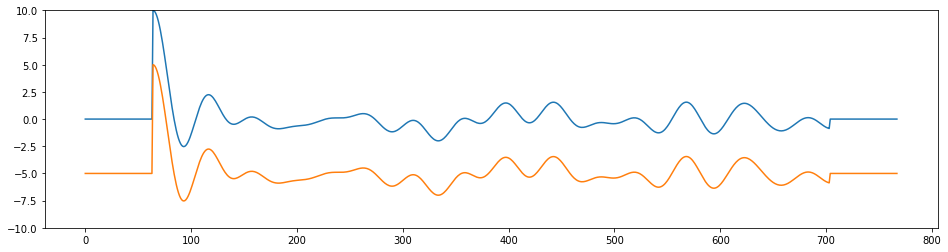

In [7]:
N = 64
M = 10
#x = np.linspace(0, 20*np.pi, num=M*N)
#x = np.cos(x) * ((x+1)/(20*np.pi)) * 2
x = sum(np.cos(np.linspace(0, x_/10, num=M*N)) for x_ in np.random.rand(100)*1000) / 10
x = np.concatenate([np.zeros((N,)), x, np.zeros((N,))])
f = np.array([[dct_iv_k_2(
                np.concatenate([
                    -np.flip(x[o+N:o+N*3//2],0) - x[o+N*3//2:o+N*2],
                    x[o:o+N//2] - np.flip(x[o+N//2:o+N],0),
                ]),k)
                for k in range(N)] for o in range(0,(M+1)*N,N)])
#f = np.where(abs(f)>0.125, f, 0)
y = np.zeros_like(x)
for i in range(len(f)):
    o = i*N
    y_ = np.array([dct_iv_k_2(f[i],k) for k in range(N*2)])
    y[o:o+N//2] += -np.flip(y_[N:N*3//2],0)
    y[o+N//2:o+N] += -np.flip(y_[N//2:N],0)
    y[o+N:o+N*3//2] += y_[N*3//2:N*2]
    y[o+N*3//2:o+N*2] += -y_[0:N//2]
plt.figure(figsize=(16,4))
plt.plot(x)
plt.plot(y-5)
plt.ylim((-10,10))
plt.show()

### a discrete cosine transform neural layer

In [8]:
import tensorflow as tf
import keras
import keras.backend as K

Using TensorFlow backend.


In [9]:
X = X_input = keras.layers.Input((None, None))
X = keras.layers.Permute((2,1))(X)
X = keras.layers.Lambda(lambda x: tf.spectral.dct(x, norm='ortho'))(X)
X = keras.layers.Permute((2,1))(X)
M_dct = keras.Model(X_input, X)
M_dct.compile('adam', 'mse')
M_dct.summary()

X = X_input = keras.layers.Input((None, None))
X = keras.layers.Permute((2,1))(X)
X = keras.layers.Lambda(lambda x: tf.spectral.idct(x, norm='ortho'))(X)
X = keras.layers.Permute((2,1))(X)
M_idct = keras.Model(X_input, X)
M_idct.compile('adam', 'mse')
M_idct.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None)        0         
_________________________________________________________________
permute_1 (Permute)          (None, None, None)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None)        0         
_________________________________________________________________
permute_2 (Permute)          (None, None, None)        0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None)        0         
_________________________________________________________________
permute_3 (Permu

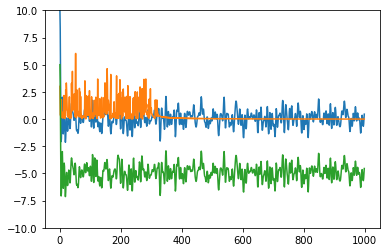

In [10]:
x = sum(np.cos(np.linspace(0, x_, num=1000)) for x_ in np.random.rand(100)*1000)/10
x = x[np.newaxis,:,np.newaxis]
f = M_dct.predict(x)
#f = np.where(abs(f)>1, f, 0)
y = M_idct.predict(f)
plt.plot(x[0,:,0])
plt.plot(abs(f[0,:,0]))
plt.plot(y[0,:,0]-5)
plt.ylim((-10,10))
plt.show()

### optimize frequence from target output sequences

In [11]:
X_train = np.array(list(range(1000)), dtype='int')
Y_train = [
    sum(np.cos(np.linspace(0, x_, num=1000)) for x_ in np.random.rand(100)*200)/10
    for _ in range(1000)
]
Y_train = np.array(Y_train)
Y_train = Y_train[:,:,np.newaxis]

In [12]:
X = X_input = keras.layers.Input((1,), dtype='int32')
X = keras.layers.Embedding(1000, 256)(X)
X = keras.layers.Reshape((-1, 1))(X)
X = keras.layers.Lambda(lambda x: K.temporal_padding(x, padding=(0, 1000-256)))(X)
X = M_idct(X)
M_embed = keras.Model(X_input, X)
M_embed.compile('adam', 'mse')
M_embed.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1, 256)            256000    
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 1)            0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1000, 1)           0         
_________________________________________________________________
model_2 (Model)              multiple                  0         
Total params: 256,000
Trainable params: 256,000
Non-trainable params: 0
_________________________________________________________________


In [13]:
M_embed.fit(X_train, Y_train, batch_size=32, epochs=1000, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', verbose=1)
])

Epoch 1/1000
1000/1000 [==============================] - 0s 473us/step - loss: 1.3294
Epoch 2/1000
1000/1000 [==============================] - 0s 281us/step - loss: 1.3269
Epoch 3/1000
1000/1000 [==============================] - 0s 211us/step - loss: 1.3244
Epoch 4/1000
1000/1000 [==============================] - 0s 213us/step - loss: 1.3218
Epoch 5/1000
1000/1000 [==============================] - 0s 276us/step - loss: 1.3192
Epoch 6/1000
1000/1000 [==============================] - 0s 279us/step - loss: 1.3165
Epoch 7/1000
1000/1000 [==============================] - 0s 274us/step - loss: 1.3139
Epoch 8/1000
1000/1000 [==============================] - 0s 247us/step - loss: 1.3113
Epoch 9/1000
1000/1000 [==============================] - 0s 219us/step - loss: 1.3087
Epoch 10/1000
1000/1000 [==============================] - 0s 270us/step - loss: 1.3060
Epoch 11/1000
1000/1000 [==============================] - 0s 251us/step - loss: 1.3034
Epoch 12/1000
1000/1000 [================

1000/1000 [==============================] - 0s 202us/step - loss: 1.1056
Epoch 95/1000
1000/1000 [==============================] - 0s 202us/step - loss: 1.1033
Epoch 96/1000
1000/1000 [==============================] - 0s 199us/step - loss: 1.1011
Epoch 97/1000
1000/1000 [==============================] - 0s 200us/step - loss: 1.0989
Epoch 98/1000
1000/1000 [==============================] - 0s 206us/step - loss: 1.0968
Epoch 99/1000
1000/1000 [==============================] - 0s 205us/step - loss: 1.0946
Epoch 100/1000
1000/1000 [==============================] - 0s 208us/step - loss: 1.0924
Epoch 101/1000
1000/1000 [==============================] - 0s 201us/step - loss: 1.0902
Epoch 102/1000
1000/1000 [==============================] - 0s 206us/step - loss: 1.0880
Epoch 103/1000
1000/1000 [==============================] - 0s 202us/step - loss: 1.0859
Epoch 104/1000
1000/1000 [==============================] - 0s 206us/step - loss: 1.0837
Epoch 105/1000
1000/1000 [===============

1000/1000 [==============================] - 0s 209us/step - loss: 0.9172
Epoch 187/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.9153
Epoch 188/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.9134
Epoch 189/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.9115
Epoch 190/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.9096
Epoch 191/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.9077
Epoch 192/1000
1000/1000 [==============================] - 0s 204us/step - loss: 0.9058
Epoch 193/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.9040
Epoch 194/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.9021
Epoch 195/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.9002
Epoch 196/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.8983
Epoch 197/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 207us/step - loss: 0.7547
Epoch 279/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.7531
Epoch 280/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.7515
Epoch 281/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.7499
Epoch 282/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.7482
Epoch 283/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.7466
Epoch 284/1000
1000/1000 [==============================] - 0s 215us/step - loss: 0.7450
Epoch 285/1000
1000/1000 [==============================] - 0s 225us/step - loss: 0.7434
Epoch 286/1000
1000/1000 [==============================] - 0s 204us/step - loss: 0.7418
Epoch 287/1000
1000/1000 [==============================] - 0s 211us/step - loss: 0.7402
Epoch 288/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.7385
Epoch 289/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 208us/step - loss: 0.6156
Epoch 371/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.6142
Epoch 372/1000
1000/1000 [==============================] - 0s 199us/step - loss: 0.6128
Epoch 373/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.6115
Epoch 374/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.6101
Epoch 375/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.6087
Epoch 376/1000
1000/1000 [==============================] - 0s 199us/step - loss: 0.6073
Epoch 377/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.6059
Epoch 378/1000
1000/1000 [==============================] - 0s 211us/step - loss: 0.6046
Epoch 379/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.6032
Epoch 380/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.6018
Epoch 381/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 202us/step - loss: 0.4975
Epoch 463/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.4964
Epoch 464/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.4952
Epoch 465/1000
1000/1000 [==============================] - 0s 223us/step - loss: 0.4940
Epoch 466/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.4929
Epoch 467/1000
1000/1000 [==============================] - 0s 214us/step - loss: 0.4917
Epoch 468/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.4905
Epoch 469/1000
1000/1000 [==============================] - 0s 204us/step - loss: 0.4894
Epoch 470/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.4882
Epoch 471/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.4870
Epoch 472/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.4859
Epoch 473/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 210us/step - loss: 0.3984
Epoch 555/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.3974
Epoch 556/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.3964
Epoch 557/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.3954
Epoch 558/1000
1000/1000 [==============================] - 0s 213us/step - loss: 0.3945
Epoch 559/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.3935
Epoch 560/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.3925
Epoch 561/1000
1000/1000 [==============================] - 0s 231us/step - loss: 0.3915
Epoch 562/1000
1000/1000 [==============================] - 0s 204us/step - loss: 0.3906
Epoch 563/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.3896
Epoch 564/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.3886
Epoch 565/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 201us/step - loss: 0.3160
Epoch 647/1000
1000/1000 [==============================] - 0s 199us/step - loss: 0.3151
Epoch 648/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.3143
Epoch 649/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.3135
Epoch 650/1000
1000/1000 [==============================] - 0s 197us/step - loss: 0.3127
Epoch 651/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.3119
Epoch 652/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.3111
Epoch 653/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.3103
Epoch 654/1000
1000/1000 [==============================] - 0s 205us/step - loss: 0.3095
Epoch 655/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.3087
Epoch 656/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.3079
Epoch 657/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 207us/step - loss: 0.2483
Epoch 739/1000
1000/1000 [==============================] - 0s 211us/step - loss: 0.2476
Epoch 740/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.2469
Epoch 741/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.2463
Epoch 742/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.2456
Epoch 743/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.2450
Epoch 744/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.2443
Epoch 745/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.2436
Epoch 746/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.2430
Epoch 747/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.2423
Epoch 748/1000
1000/1000 [==============================] - 0s 209us/step - loss: 0.2417
Epoch 749/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 200us/step - loss: 0.1932
Epoch 831/1000
1000/1000 [==============================] - 0s 212us/step - loss: 0.1927
Epoch 832/1000
1000/1000 [==============================] - 0s 202us/step - loss: 0.1922
Epoch 833/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.1916
Epoch 834/1000
1000/1000 [==============================] - 0s 211us/step - loss: 0.1911
Epoch 835/1000
1000/1000 [==============================] - 0s 207us/step - loss: 0.1906
Epoch 836/1000
1000/1000 [==============================] - 0s 207us/step - loss: 0.1901
Epoch 837/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.1895
Epoch 838/1000
1000/1000 [==============================] - 0s 203us/step - loss: 0.1890
Epoch 839/1000
1000/1000 [==============================] - 0s 207us/step - loss: 0.1885
Epoch 840/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.1879
Epoch 841/1000
1000/1000 [==========

1000/1000 [==============================] - 0s 203us/step - loss: 0.1490
Epoch 923/1000
1000/1000 [==============================] - 0s 204us/step - loss: 0.1486
Epoch 924/1000
1000/1000 [==============================] - 0s 211us/step - loss: 0.1482
Epoch 925/1000
1000/1000 [==============================] - 0s 198us/step - loss: 0.1477
Epoch 926/1000
1000/1000 [==============================] - 0s 208us/step - loss: 0.1473
Epoch 927/1000
1000/1000 [==============================] - 0s 210us/step - loss: 0.1469
Epoch 928/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.1465
Epoch 929/1000
1000/1000 [==============================] - 0s 201us/step - loss: 0.1460
Epoch 930/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.1456
Epoch 931/1000
1000/1000 [==============================] - 0s 200us/step - loss: 0.1452
Epoch 932/1000
1000/1000 [==============================] - 0s 206us/step - loss: 0.1448
Epoch 933/1000
1000/1000 [==========

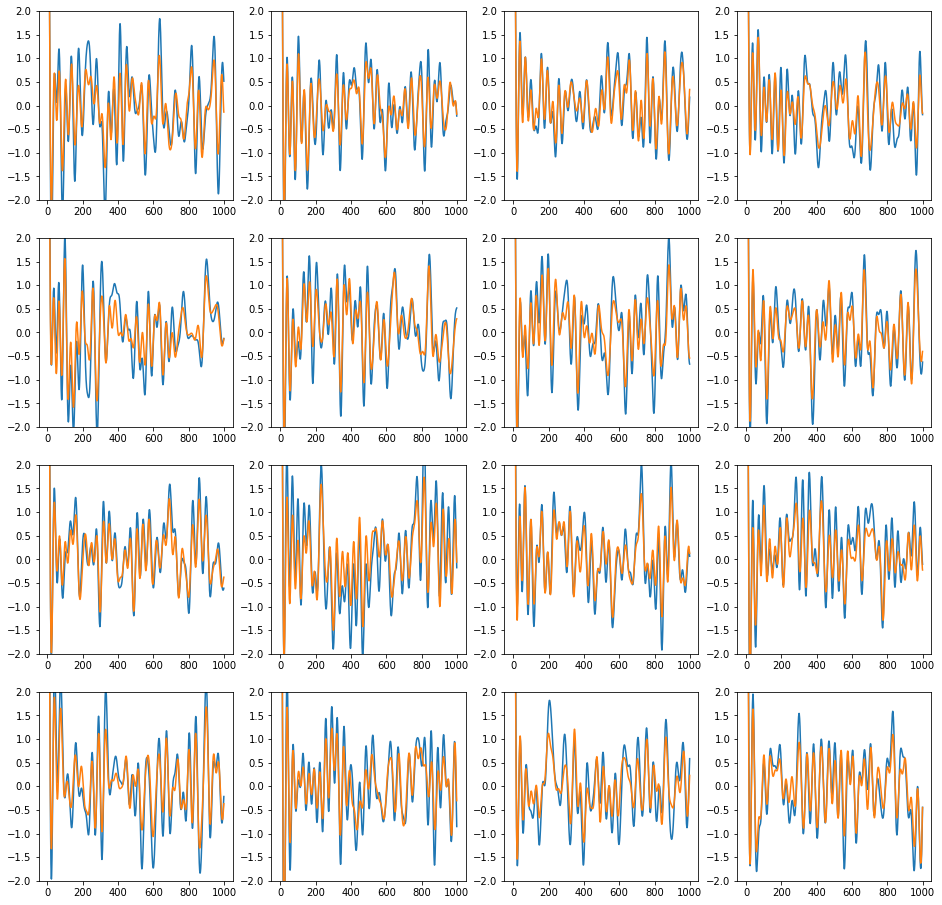

In [14]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    pred = M_embed.predict(X_train[i:i+1])
    plt.plot(Y_train[i,:,0])
    plt.plot(pred[0,:,0])
    plt.ylim((-2,2))
plt.show()

### regress one sequence to another target sequence through freq. domain

In [15]:
X_train_2, Y_train_2 = [[
    sum(np.cos(np.linspace(0, x_, num=1000)) for x_ in np.random.rand(100)*200)/10
    for _ in range(1000)
] for _ in range(2)]
X_train_2, Y_train_2 = np.array(X_train_2), np.array(Y_train_2)
X_train_2, Y_train_2 = X_train_2[:,:,np.newaxis], Y_train_2[:,:,np.newaxis]

In [16]:
X = X_input = keras.layers.Input((None, 1))
X = M_dct(X)
X = keras.layers.Lambda(lambda x: x[:,:256,:])(X)
X = keras.layers.Reshape((-1, 1))(X)

#X = keras.layers.LSTM(128, return_sequences=True)(X)
#X = keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu'))(X)
#X = keras.layers.TimeDistributed(keras.layers.Dense(1))(X)

X = keras.layers.Reshape((256,))(X)
X = keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform')(X)
X = keras.layers.Dense(256, activation=None, kernel_initializer='he_uniform')(X)
X = keras.layers.Reshape((-1, 1))(X)

X = keras.layers.Lambda(lambda x: K.temporal_padding(x, padding=(0, 1000-256)))(X)
X = M_idct(X)
M_regress = keras.Model(X_input, X)
M_regress.compile('adam', 'mse')
M_regress.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
model_1 (Model)              (None, None, None)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, None, None)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, None, 1)           0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [17]:
M_regress.fit(X_train_2, Y_train_2, batch_size=32, epochs=500, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', verbose=1)
])

Epoch 1/500
1000/1000 [==============================] - 1s 525us/step - loss: 1.2281
Epoch 2/500
1000/1000 [==============================] - 0s 242us/step - loss: 0.6629
Epoch 3/500
1000/1000 [==============================] - 0s 247us/step - loss: 0.5876
Epoch 4/500
1000/1000 [==============================] - 0s 258us/step - loss: 0.5498
Epoch 5/500
1000/1000 [==============================] - 0s 250us/step - loss: 0.5295
Epoch 6/500
1000/1000 [==============================] - 0s 262us/step - loss: 0.5160
Epoch 7/500
1000/1000 [==============================] - 0s 257us/step - loss: 0.5066
Epoch 8/500
1000/1000 [==============================] - 0s 253us/step - loss: 0.4992
Epoch 9/500
1000/1000 [==============================] - 0s 356us/step - loss: 0.4928
Epoch 10/500
1000/1000 [==============================] - 0s 255us/step - loss: 0.4870
Epoch 11/500
1000/1000 [==============================] - 0s 255us/step - loss: 0.4811
Epoch 12/500
1000/1000 [============================

1000/1000 [==============================] - 0s 245us/step - loss: 0.1186
Epoch 96/500
1000/1000 [==============================] - 0s 265us/step - loss: 0.1171
Epoch 97/500
1000/1000 [==============================] - 0s 247us/step - loss: 0.1153
Epoch 98/500
1000/1000 [==============================] - 0s 244us/step - loss: 0.1136
Epoch 99/500
1000/1000 [==============================] - 0s 242us/step - loss: 0.1118
Epoch 100/500
1000/1000 [==============================] - 0s 242us/step - loss: 0.1107
Epoch 101/500
1000/1000 [==============================] - 0s 243us/step - loss: 0.1086
Epoch 102/500
1000/1000 [==============================] - 0s 243us/step - loss: 0.1071
Epoch 103/500
1000/1000 [==============================] - 0s 240us/step - loss: 0.1054
Epoch 104/500
1000/1000 [==============================] - 0s 244us/step - loss: 0.1040
Epoch 105/500
1000/1000 [==============================] - 0s 249us/step - loss: 0.1028
Epoch 106/500
1000/1000 [=========================

1000/1000 [==============================] - 0s 266us/step - loss: 0.0441
Epoch 189/500
1000/1000 [==============================] - 0s 271us/step - loss: 0.0439
Epoch 190/500
1000/1000 [==============================] - 0s 266us/step - loss: 0.0435
Epoch 191/500
1000/1000 [==============================] - 0s 266us/step - loss: 0.0430
Epoch 192/500
1000/1000 [==============================] - 0s 265us/step - loss: 0.0431
Epoch 193/500
1000/1000 [==============================] - 0s 265us/step - loss: 0.0428
Epoch 194/500
1000/1000 [==============================] - 0s 267us/step - loss: 0.0425
Epoch 195/500
1000/1000 [==============================] - 0s 272us/step - loss: 0.0419
Epoch 196/500
1000/1000 [==============================] - 0s 277us/step - loss: 0.0416
Epoch 197/500
1000/1000 [==============================] - 0s 272us/step - loss: 0.0413
Epoch 198/500
1000/1000 [==============================] - 0s 280us/step - loss: 0.0410
Epoch 199/500
1000/1000 [=====================

1000/1000 [==============================] - 0s 309us/step - loss: 0.0264
Epoch 282/500
1000/1000 [==============================] - 0s 312us/step - loss: 0.0264
Epoch 283/500
1000/1000 [==============================] - 0s 284us/step - loss: 0.0262
Epoch 284/500
1000/1000 [==============================] - 0s 313us/step - loss: 0.0261
Epoch 285/500
1000/1000 [==============================] - 0s 307us/step - loss: 0.0259
Epoch 286/500
1000/1000 [==============================] - 0s 302us/step - loss: 0.0255
Epoch 287/500
1000/1000 [==============================] - 0s 292us/step - loss: 0.0258
Epoch 288/500
1000/1000 [==============================] - 0s 305us/step - loss: 0.0255
Epoch 289/500
1000/1000 [==============================] - 0s 274us/step - loss: 0.0253
Epoch 290/500
1000/1000 [==============================] - 0s 314us/step - loss: 0.0254
Epoch 291/500
1000/1000 [==============================] - 0s 324us/step - loss: 0.0254
Epoch 292/500
1000/1000 [=====================

1000/1000 [==============================] - 0s 245us/step - loss: 0.0191
Epoch 375/500
1000/1000 [==============================] - 0s 241us/step - loss: 0.0191
Epoch 376/500
1000/1000 [==============================] - 0s 244us/step - loss: 0.0186
Epoch 377/500
1000/1000 [==============================] - 0s 242us/step - loss: 0.0185
Epoch 378/500
1000/1000 [==============================] - 0s 250us/step - loss: 0.0188
Epoch 379/500
1000/1000 [==============================] - 0s 248us/step - loss: 0.0188
Epoch 380/500
1000/1000 [==============================] - 0s 252us/step - loss: 0.0184
Epoch 381/500
1000/1000 [==============================] - 0s 242us/step - loss: 0.0185
Epoch 382/500
1000/1000 [==============================] - 0s 248us/step - loss: 0.0186
Epoch 383/500
1000/1000 [==============================] - 0s 249us/step - loss: 0.0185
Epoch 384/500
1000/1000 [==============================] - 0s 241us/step - loss: 0.0185
Epoch 385/500
1000/1000 [=====================

1000/1000 [==============================] - 0s 270us/step - loss: 0.0108
Epoch 467/500
1000/1000 [==============================] - 0s 301us/step - loss: 0.0108
Epoch 468/500
1000/1000 [==============================] - 0s 259us/step - loss: 0.0108
Epoch 469/500
1000/1000 [==============================] - 0s 323us/step - loss: 0.0108
Epoch 470/500
1000/1000 [==============================] - 0s 256us/step - loss: 0.0108
Epoch 471/500
1000/1000 [==============================] - 0s 267us/step - loss: 0.0108
Epoch 472/500
1000/1000 [==============================] - 0s 319us/step - loss: 0.0108
Epoch 473/500
1000/1000 [==============================] - 0s 304us/step - loss: 0.0108
Epoch 474/500
1000/1000 [==============================] - 0s 270us/step - loss: 0.0108
Epoch 475/500
1000/1000 [==============================] - 0s 326us/step - loss: 0.0107

Epoch 00475: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 476/500
1000/1000 [===========================

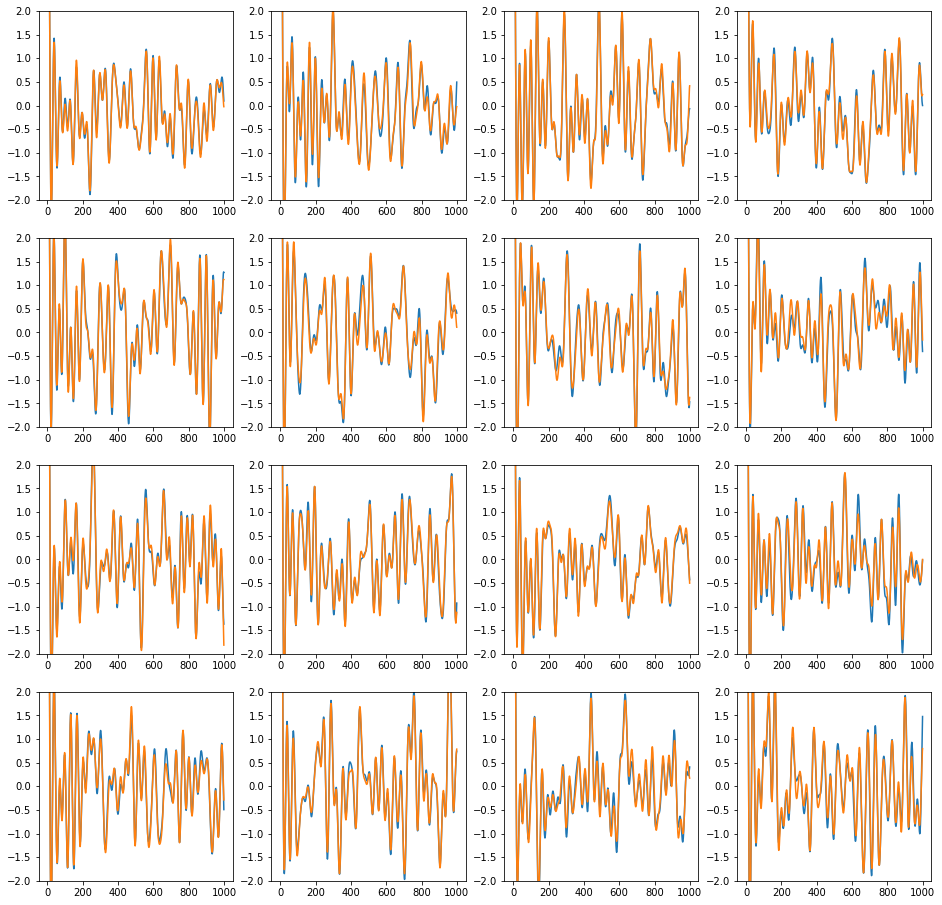

In [18]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    pred = M_regress.predict(X_train_2[i:i+1])
    plt.plot(Y_train_2[i,:,0])
    plt.plot(pred[0,:,0])
    plt.ylim((-2,2))
plt.show()